<a href="https://colab.research.google.com/github/khloud-ibrahim/blank-app/blob/main/Copy_of_Mining_finaltask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("AD CAMPAIGN PREDICTION MODEL")
print("="*70)

AD CAMPAIGN PREDICTION MODEL


In [3]:
import os
print("Files in current directory:")
print(os.listdir())

Files in current directory:
['.config', 'sample_data']


In [4]:
from google.colab import files
uploaded = files.upload()
# بعدين اختار الملف من جهازك

Saving GoogleAds_DataAnalytics_Sales_Uncleaned.csv to GoogleAds_DataAnalytics_Sales_Uncleaned.csv


In [5]:
#1. LOAD DATA
# ============================================================================
data = pd.read_csv('GoogleAds_DataAnalytics_Sales_Uncleaned.csv')  # غير اسم الملف هنا
print("\n✓ Data loaded successfully")
print(f"Dataset shape: {data.shape}")
print("\nOriginal columns:", data.columns.tolist())


✓ Data loaded successfully
Dataset shape: (2600, 13)

Original columns: ['Ad_ID', 'Campaign_Name', 'Clicks', 'Impressions', 'Cost', 'Leads', 'Conversions', 'Conversion Rate', 'Sale_Amount', 'Ad_Date', 'Location', 'Device', 'Keyword']


In [6]:
# ============================================================================
# 2. CLEAN COLUMN NAMES
# ============================================================================
data.columns = data.columns.str.replace(' ', '_')
print("\n✓ Column names cleaned")
print("Cleaned columns:", data.columns.tolist())


✓ Column names cleaned
Cleaned columns: ['Ad_ID', 'Campaign_Name', 'Clicks', 'Impressions', 'Cost', 'Leads', 'Conversions', 'Conversion_Rate', 'Sale_Amount', 'Ad_Date', 'Location', 'Device', 'Keyword']


In [7]:
# ============================================================================
# 3. CLEAN NUMERIC COLUMNS (Remove $ and commas)
# ============================================================================
print("\n" + "="*70)
print("CLEANING NUMERIC COLUMNS")
print("="*70)

numeric_cols_to_clean = ['Cost', 'Sale_Amount']
for col in numeric_cols_to_clean:
    if col in data.columns:
        print(f"\nCleaning {col}...")
        print(f"  Before: {data[col].head(3).tolist()}")
        data[col] = data[col].astype(str).str.replace('$', '', regex=False)
        data[col] = data[col].str.replace(',', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce')
        print(f"  After: {data[col].head(3).tolist()}")

print("\n✓ Numeric columns cleaned")


CLEANING NUMERIC COLUMNS

Cleaning Cost...
  Before: ['$231.88', '$216.84', '$203.66']
  After: [231.88, 216.84, 203.66]

Cleaning Sale_Amount...
  Before: ['$1892', '$1679', '$1624']
  After: [1892.0, 1679.0, 1624.0]

✓ Numeric columns cleaned


In [8]:
# ============================================================================
# 4. HANDLE DATE COLUMN
# ============================================================================
print("\n" + "="*70)
print("PROCESSING DATE FEATURES")
print("="*70)

if 'Ad_Date' in data.columns:
    print("\nProcessing Ad_Date column...")
    print(f"Sample dates: {data['Ad_Date'].head(3).tolist()}")

    data['Ad_Date'] = pd.to_datetime(data['Ad_Date'], errors='coerce')

    # Extract date features
    data['Year'] = data['Ad_Date'].dt.year
    data['Month'] = data['Ad_Date'].dt.month
    data['Day'] = data['Ad_Date'].dt.day
    data['DayOfWeek'] = data['Ad_Date'].dt.dayofweek

    # Drop original date column
    data = data.drop(['Ad_Date'], axis=1)
    print("✓ Date features extracted: Year, Month, Day, DayOfWeek")
else:
    print("⚠ Ad_Date column not found")



PROCESSING DATE FEATURES

Processing Ad_Date column...
Sample dates: ['2024-11-16', '20-11-2024', '2024/11/16']
✓ Date features extracted: Year, Month, Day, DayOfWeek


In [9]:
# ============================================================================
# 5. HANDLE MISSING VALUES
# ============================================================================
print("\n" + "="*70)
print("HANDLING MISSING VALUES")
print("="*70)

print("\nMissing values per column:")
missing = data.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    data = data.dropna()
    print(f"\n✓ Dropped rows with missing values")
    print(f"New dataset shape: {data.shape}")
else:
    print("✓ No missing values found")


HANDLING MISSING VALUES

Missing values per column:
Clicks              112
Impressions          54
Cost                 97
Leads                48
Conversions          74
Conversion_Rate     626
Sale_Amount         139
Year               1707
Month              1707
Day                1707
DayOfWeek          1707
dtype: int64

✓ Dropped rows with missing values
New dataset shape: (602, 16)


In [10]:

# ============================================================================
# 6. ENCODE CATEGORICAL VARIABLES
# ============================================================================
print("\n" + "="*70)
print("ENCODING CATEGORICAL VARIABLES")
print("="*70)

categorical_cols = ['Campaign_Name', 'Location', 'Device', 'Keyword']
categorical_cols = [col for col in categorical_cols if col in data.columns]

print(f"\nCategorical columns to encode: {categorical_cols}")
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
print(f"✓ Encoding complete")
print(f"Dataset shape after encoding: {data_encoded.shape}")


ENCODING CATEGORICAL VARIABLES

Categorical columns to encode: ['Campaign_Name', 'Location', 'Device', 'Keyword']
✓ Encoding complete
Dataset shape after encoding: (602, 31)


In [11]:

# ============================================================================
# 7. PREPARE FEATURES AND TARGET
# ============================================================================
print("\n" + "="*70)
print("PREPARING FEATURES AND TARGET")
print("="*70)

# Choose target variable
target_variable = 'Conversions'  # غير ده لـ: Sale_Amount, Leads, أو Conversion_Rate

# Drop Ad_ID (identifier)
if 'Ad_ID' in data_encoded.columns:
    data_encoded = data_encoded.drop(['Ad_ID'], axis=1)

# Separate features and target
X = data_encoded.drop([target_variable], axis=1)
y = data_encoded[target_variable]

print(f"\nTarget variable: {target_variable}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")


PREPARING FEATURES AND TARGET

Target variable: Conversions
Number of features: 29
Number of samples: 602

Target statistics:
  Mean: 6.50
  Std: 2.29
  Min: 3.00
  Max: 10.00



FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
  1. Conversion_Rate: 0.5951
  2. Clicks: 0.1968
  3. Sale_Amount: 0.0349
  4. Cost: 0.0322
  5. Leads: 0.0241
  6. Impressions: 0.0231
  7. Day: 0.0198
  8. DayOfWeek: 0.0150
  9. Device_tablet: 0.0058
  10. Keyword_data analitics online: 0.0050
  11. Campaign_Name_Data Anlytics Corse: 0.0041
  12. Device_MOBILE: 0.0039
  13. Campaign_Name_DataAnalyticsCourse: 0.0037
  14. Device_mobile: 0.0036
  15. Location_hydrebad: 0.0036


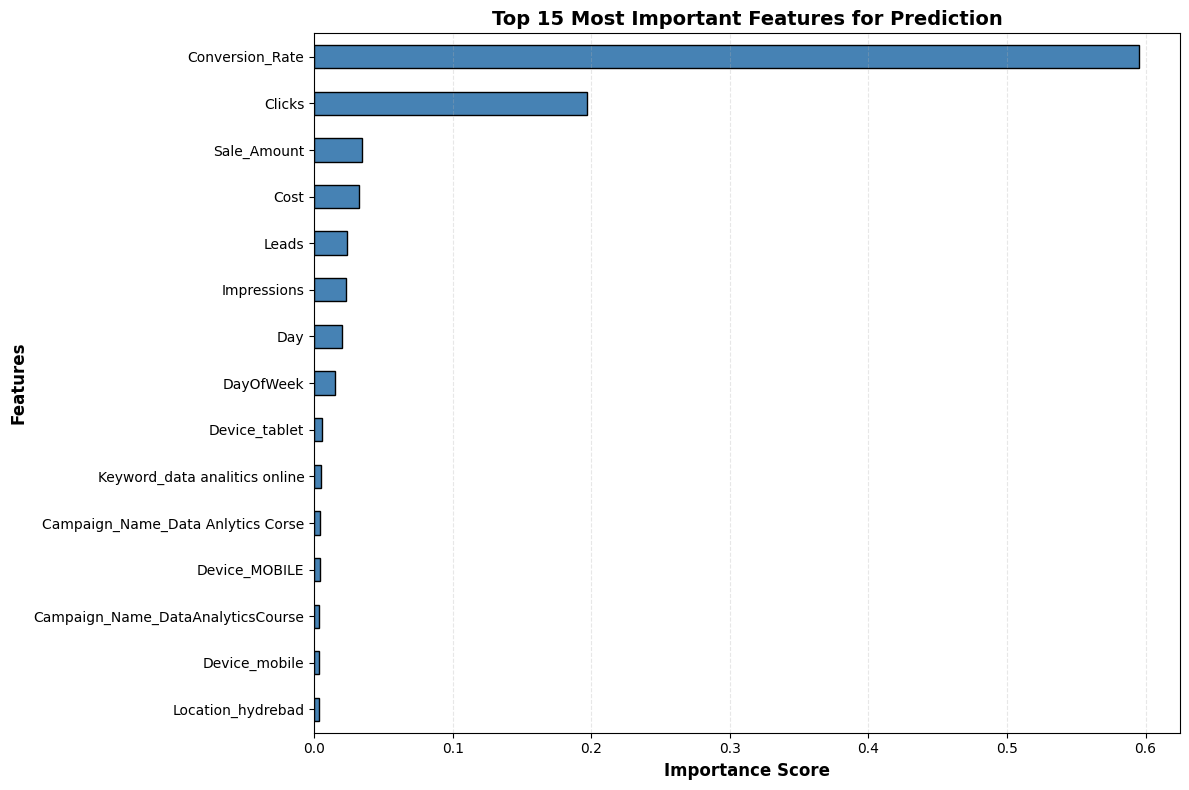


✓ Feature importance chart displayed


In [12]:
# ============================================================================
# 8. FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
importances = rf_temp.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

print("\nTop 15 Most Important Features:")
top_features = feat_importances.nlargest(15)
for i, (feat, imp) in enumerate(top_features.items(), 1):
    print(f"  {i}. {feat}: {imp:.4f}")



# Visualize Feature Importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_features.sort_values().plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features for Prediction', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Feature importance chart displayed")


In [13]:
# ============================================================================
# 9. FEATURE SELECTION
# ============================================================================
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

k_features = min(30, X.shape[1])
selector = SelectKBest(f_regression, k=k_features)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X_selected = pd.DataFrame(X_selected, columns=selected_features)

print(f"\n✓ Selected {len(selected_features)} features")
print(f"Selected features: {selected_features.tolist()}")


FEATURE SELECTION

✓ Selected 29 features
Selected features: ['Clicks', 'Impressions', 'Cost', 'Leads', 'Conversion_Rate', 'Sale_Amount', 'Year', 'Month', 'Day', 'DayOfWeek', 'Campaign_Name_Data Analytics Corse', 'Campaign_Name_Data Anlytics Corse', 'Campaign_Name_DataAnalyticsCourse', 'Location_Hyderbad', 'Location_hyderabad', 'Location_hydrebad', 'Device_Desktop', 'Device_MOBILE', 'Device_Mobile', 'Device_TABLET', 'Device_Tablet', 'Device_desktop', 'Device_mobile', 'Device_tablet', 'Keyword_data analitics online', 'Keyword_data analytics course', 'Keyword_data anaytics training', 'Keyword_learn data analytics', 'Keyword_online data analytic']


In [14]:
# ============================================================================
# 10. FEATURE SCALING
# ============================================================================
print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_selected)
print("✓ Features scaled using MinMaxScaler")


FEATURE SCALING
✓ Features scaled using MinMaxScaler


In [15]:
# ============================================================================
# 11. SPLIT DATA
# ============================================================================
print("\n" + "="*70)
print("SPLITTING DATA")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


SPLITTING DATA

Training set: 481 samples
Test set: 121 samples


In [17]:

# ============================================================================
# 12. TRAIN MODELS
# ============================================================================
print("\n" + "="*70)
print("TRAINING MACHINE LEARNING MODELS")
print("="*70)

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVM': SVR(kernel='rbf'),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Ensemble models
voting_reg = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

stacking_reg = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ],
    final_estimator=LinearRegression()
)

models['Voting Ensemble'] = voting_reg
models['Stacking Ensemble'] = stacking_reg


TRAINING MACHINE LEARNING MODELS


In [18]:
# ============================================================================
# 13. EVALUATE MODELS
# ============================================================================
results = []
best_model = None
best_model_name = ""
best_r2 = -float('inf')

for name, model in models.items():
    print(f"\nTraining {name}...", end=" ")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    print("✓ Done")

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name


Training Linear Regression... ✓ Done

Training KNN... ✓ Done

Training SVM... ✓ Done

Training Decision Tree... ✓ Done

Training Random Forest... ✓ Done

Training Gradient Boosting... ✓ Done

Training XGBoost... ✓ Done

Training Voting Ensemble... ✓ Done

Training Stacking Ensemble... ✓ Done


In [19]:
# ============================================================================
# 14. DISPLAY RESULTS
# ============================================================================
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False)
print("\n" + results_df.to_string(index=False))

print("\n" + "="*70)
print("BEST MODEL")
print("="*70)
print(f"\nModel: {best_model_name}")
print(f"R² Score: {best_r2:.4f}")
print(f"RMSE: {results_df[results_df['Model'] == best_model_name]['RMSE'].values[0]:.2f}")
print(f"MAE: {results_df[results_df['Model'] == best_model_name]['MAE'].values[0]:.2f}")



MODEL PERFORMANCE COMPARISON

            Model      MSE     RMSE      MAE        R2
Stacking Ensemble 1.889253 1.374501 0.885037  0.598948
Gradient Boosting 1.953794 1.397782 0.909322  0.585247
    Random Forest 1.967996 1.402853 0.900215  0.582232
  Voting Ensemble 1.995916 1.412769 0.918427  0.576305
Linear Regression 2.256329 1.502108 1.009272  0.521025
          XGBoost 2.395196 1.547642 1.045222  0.491546
              SVM 3.051812 1.746944 1.476505  0.352159
    Decision Tree 3.571515 1.889845 1.197077  0.241836
              KNN 5.643636 2.375634 2.082645 -0.198035

BEST MODEL

Model: Stacking Ensemble
R² Score: 0.5989
RMSE: 1.37
MAE: 0.89


In [20]:

# ============================================================================
# 15. SAVE MODEL AND PREPROCESSING OBJECTS
# ============================================================================
print("\n" + "="*70)
print("SAVING MODEL AND PREPROCESSING OBJECTS")
print("="*70)

joblib.dump(best_model, 'best_ad_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'selector.pkl')
joblib.dump(selected_features.tolist(), 'selected_features.pkl')

print("\n✓ Files saved successfully:")
print("  - best_ad_model.pkl")
print("  - scaler.pkl")
print("  - selector.pkl")
print("  - selected_features.pkl")


SAVING MODEL AND PREPROCESSING OBJECTS

✓ Files saved successfully:
  - best_ad_model.pkl
  - scaler.pkl
  - selector.pkl
  - selected_features.pkl


In [21]:
# ============================================================================
# 16. EXAMPLE PREDICTIONS
# ============================================================================
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

n_samples = min(5, len(X_test))
sample_predictions = best_model.predict(X_test[:n_samples])
sample_actual = y_test.iloc[:n_samples].values

print(f"\nPredicting {target_variable}:")
print("\n{:<15} {:<15} {:<15} {:<15}".format("Actual", "Predicted", "Difference", "Error %"))
print("-" * 60)
for i in range(n_samples):
    actual = sample_actual[i]
    predicted = sample_predictions[i]
    diff = actual - predicted
    error_pct = abs(diff / actual * 100) if actual != 0 else 0
    print("{:<15.2f} {:<15.2f} {:<15.2f} {:<15.2f}%".format(
        actual, predicted, diff, error_pct
    ))

print("\n" + "="*70)
print("MODEL TRAINING COMPLETE!")
print("="*70)


SAMPLE PREDICTIONS

Predicting Conversions:

Actual          Predicted       Difference      Error %        
------------------------------------------------------------
7.00            6.14            0.86            12.25          %
7.00            6.46            0.54            7.68           %
4.00            6.39            -2.39           59.75          %
3.00            5.53            -2.53           84.23          %
9.00            9.38            -0.38           4.18           %

MODEL TRAINING COMPLETE!
